# Seasonality Extractor
Imports data from G-Sheets, flags outliers & holidays + calculates seasonality

In [1]:
import Bens_forecasting_utils as fc
import pandas as pd
%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['figure.figsize'] = [10, 5] # make default plot size bigger
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

### Set parameters here:

In [2]:
parameters = dict(
    
    input_sheet_id             = '1-pAeePhJ6Q5tc9nLGDacmDte_rYxbcHtQXSm9ZEDajg',
    input_sheet_range          = 'raw!A1:C',
    holidays_sheet_id          = '1DDMBg8-q5SuPpeL1ZqC8vs7D9U-_b_F0dIroFBsNvEk',
    holidays_sheet_range       = 'holidays!A1:E',
    stddev_threshold           = 2.0,
    outlier_rolling_window     = 13,
    monthly_seasonality_window = 24,
    wrap_monthly_seasonality   = False,
    weekly_seasonality_window  = 26,
    enable_verbose_logging     = True    # Requires kernel restart to take effect
)

**Note:** first time run will prompt authorisation with Google SSO for the G-Sheets API. After that a `token.json` file will be stored locally containing API credentials.

Credentials will remain valid unless they are not used for 6 months (or if the API scope is changed in `Bens_forecasting_utils.py`). In this case you may need to manually delete `token.json` to trigger the Google SSO authorisation flow upon the next execution.

---

### Import raw data and do pre-processing:
Flag Outliers, Holidays & extract intra-month & intra-week seasonality.

In [3]:
%%time

df_dict = fc.main(**parameters)

df_raw_vol = df_dict[0]
df_intra_month_seasonality = df_dict[1]
df_intra_week_seasonality = df_dict[2]

INFO: Verbose logging enabled (level=logging.INFO)
INFO: Script start time: 10/01/2025 11:32:50
INFO: Importing range: 'raw!A1:C' from G-sheet with id: '1-pAeePhJ6Q5tc9nLGDacmDte_rYxbcHtQXSm9ZEDajg'
INFO:     G-Sheets API Credentials: token.json exists
INFO:     User credentials expired, refreshing
INFO: Importing range: 'holidays!A1:E' from G-sheet with id: '1DDMBg8-q5SuPpeL1ZqC8vs7D9U-_b_F0dIroFBsNvEk'
INFO:     G-Sheets API Credentials: token.json exists
INFO: Begin outlier detection:
INFO:     initial outlier count: 501
INFO:     new outlier count: 636
INFO:     new outlier count: 666
INFO:     new outlier count: 672
INFO:     new outlier count: 673
INFO:     new outlier count: 673
INFO: get_intra_week_distro: window_size: 26
INFO: get_intra_month_seasonality: window size: 24
raw seasonality null check: 0
CPU times: user 535 ms, sys: 93.3 ms, total: 629 ms
Wall time: 2.94 s


/Users/krisi.afezolli/Desktop/Folder/Bens_forecasting_utils.py:545: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.78571429e+01 5.93571429e+02 2.86000000e+02 4.82857143e+01
 6.19285714e+02 2.86000000e+02 3.27500000e+02 6.75000000e+01
 1.89750000e+02 1.67500000e+03 2.62333333e+02 7.60777778e+02
 5.54000000e+02 1.29266667e+03 2.64444444e+02 5.39909091e+02
 4.56800000e+02 3.35181818e+02 1.60181818e+02 2.74454545e+02
 7.90833333e+01 1.28409091e+03 2.00272727e+02 6.60916667e+02
 3.55833333e+01 8.41272727e+02 9.32818182e+02 4.66454545e+02
 3.70250000e+02 7.39545455e+02 3.73583333e+02 8.41727273e+02
 5.51444444e+02 2.65400000e+02 1.22609091e+03 3.41333333e+02
 3.30166667e+02 5.22000000e+02 5.59222222e+02 1.62872727e+03
 8.24090909e+02 9.44636364e+02 2.08916667e+02 7.76923077e+00
 1.62700000e+03 1.43118182e+03 8.10000000e+01 1.64400000e+03
 1.06861538e+03 3.94166667e+01 2.00000000e+00 6.45250000e+02
 2.9650000

interactive(children=(Dropdown(description='business_line', options=('ops-cs-L1-de-call', 'ops-cs-L1-de-callba…

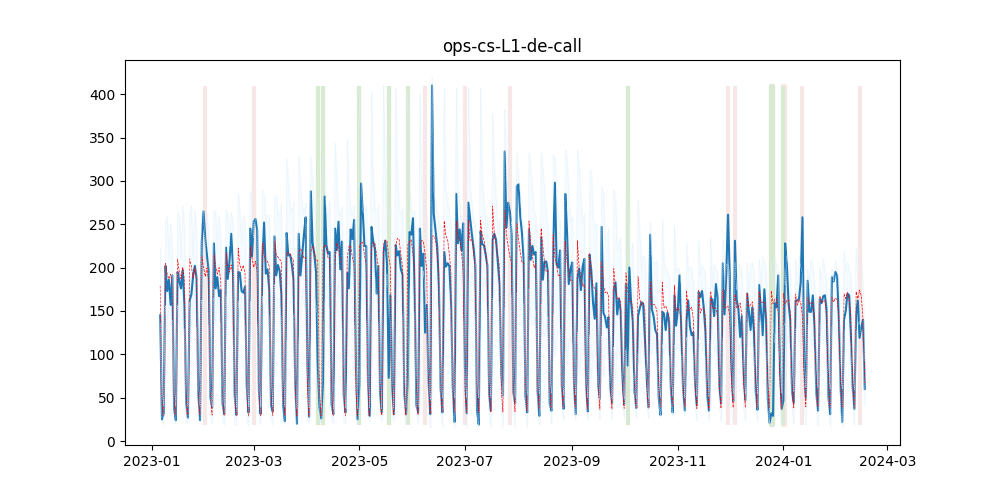

In [4]:
def plot_vol(business_line):
    graphData = df_raw_vol.loc[(df_raw_vol['business_line_alias'] == business_line) & (df_raw_vol['date'] > '2020-01-01') & (df_raw_vol['date'] < '2024-02-18')]
    plt.figure(1)
    plotMax = max(graphData['value'])
    plotMin = min(graphData['value'])
    plt.clf()
    plt.plot(graphData['date'], graphData['value'])
    plt.plot(graphData['date'], graphData['rolling_mean'], color='red', linewidth=0.5, linestyle='--')
    plt.plot(graphData['date'], graphData['low_outlier_threshold'], color='#dfeffa', linewidth=0.3, linestyle='--')
    plt.plot(graphData['date'], graphData['high_outlier_threshold'], color='#dfeffa', linewidth=0.3, linestyle='--')
    plt.fill_between(graphData['date'], graphData['low_outlier_threshold'], graphData['high_outlier_threshold'], color='#f5fbff')
    plt.fill_between(graphData['date'], plotMin, plotMax, where=graphData['is_stdv_stats_outlier'] == True, color='#f8e7e7', linewidth=3)
    plt.fill_between(graphData['date'], plotMin, plotMax, where=graphData['is_holiday'] == True,color='#d9ead3', linewidth=3)
    plt.title(graphData['business_line_alias'].iat[0])

dropdown = widgets.interact(
    plot_vol, 
    business_line=df_raw_vol['business_line_alias'].unique()
)

# Key:
# blue line = value           red dotted line = local avg           blue area = outlier upper/lower bounds
# red bar  = outlier          green bar = national holiday

Note: running a chart cell twice will cause the chart to dissappear. (This is [intended behaviour](https://github.com/matplotlib/ipympl/issues/60) for some reason 🤷‍♂️).

To fix: re-run the first cell in the notebook (containing the `%matplotlib ipympl` magic command), then re-run the chart cell again.

interactive(children=(Dropdown(description='business_line', options=('ops-cs-L1-de-call', 'ops-cs-L1-de-callba…

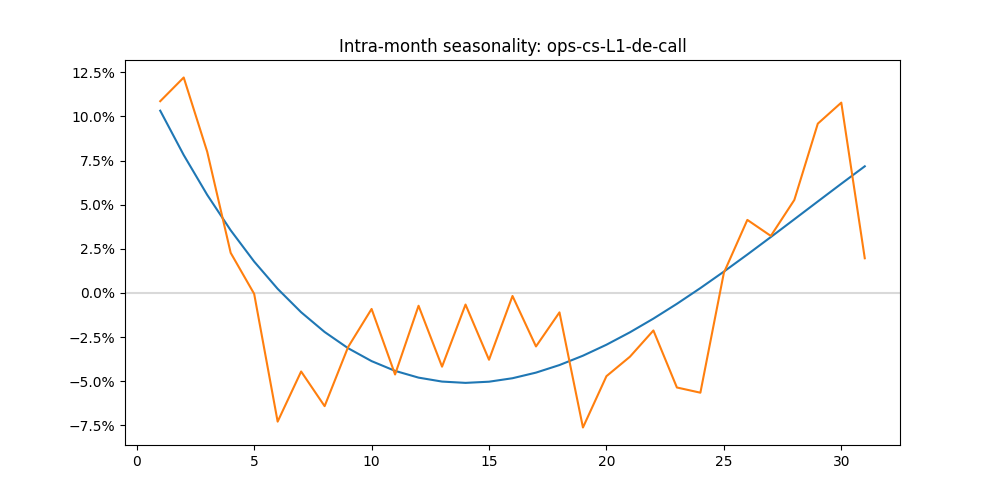

In [5]:
def plot_intra_month_seasonality(business_line):
    graphData = df_intra_month_seasonality.loc[(df_intra_month_seasonality['business_line_alias'] == business_line)]
    plt.figure(2)
    plotMax = max(graphData['avg_vol'])
    plt.clf()
    plt.axhline(0, color="black", alpha=0.15)
    plt.plot(graphData['dom'], graphData['intra_month_seasonality'])
    plt.plot(graphData['dom'], graphData['avg_vol'])
    plt.title('Intra-month seasonality: ' + graphData['business_line_alias'].iat[0])
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

dropdown = widgets.interact(
    plot_intra_month_seasonality, 
    business_line=df_intra_month_seasonality['business_line_alias'].unique()
)

# Key:
# blue line = smoothing spline seasonality          orange bar  = raw seasonality

interactive(children=(Dropdown(description='business_line', options=('ops-cs-L1-de-call', 'ops-cs-L1-de-callba…

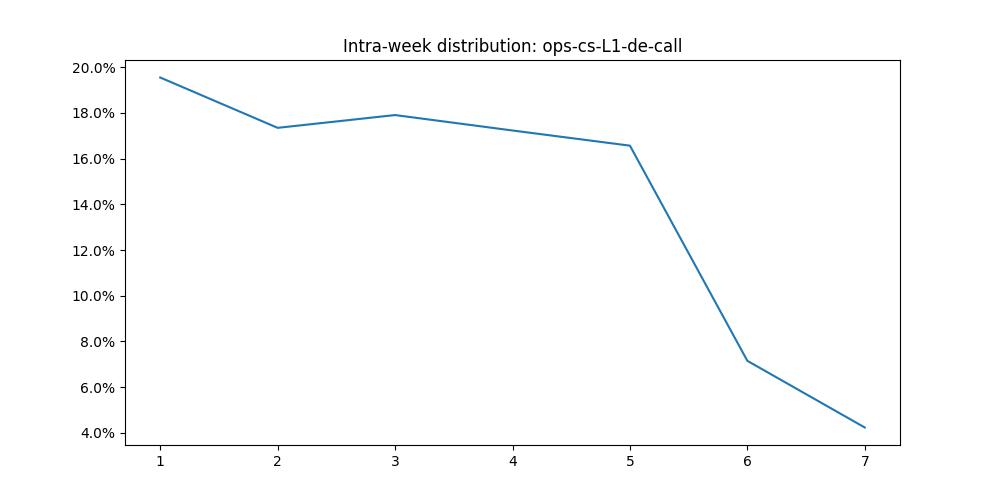

In [6]:
def plot_intra_week_seasonality(business_line):
    graphData = df_intra_week_seasonality.loc[(df_intra_week_seasonality['business_line_alias'] == business_line)]
    plt.figure(3)
    plotMax = max(graphData['avg_vol'])
    plt.clf()
    plt.plot(graphData['dow'], graphData['intra_week_distro'])
    #plt.plot(graphData['dow'], graphData['avg_vol'])
    plt.title('Intra-week distribution: ' + graphData['business_line_alias'].iat[0])
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

dropdown = widgets.interact(
    plot_intra_week_seasonality, 
    business_line=df_intra_week_seasonality['business_line_alias'].unique()
)

# Key:
# blue line = intra-week split

In [7]:


intra_month_gsheet_export_params = dict(
    
    df                 = df_intra_month_seasonality,
    gsheet_id          = parameters['input_sheet_id'], #export to input sheet
    gsheet_tab_name    = 'intra-month_seasonality',
    include_df_headers = True,
    tab_colour         = (0.0, 0.0, 0.0) #RGB tab colour
)

intra_week_gsheet_export_params = dict(
    
    df                 = df_intra_week_seasonality,
    gsheet_id          = parameters['input_sheet_id'], #export to input sheet
    gsheet_tab_name    = 'intra-week_seasonality',
    include_df_headers = True,
    tab_colour         = (0.0, 0.0, 0.0) #RGB tab colour
)

# The date column must be converted to a string because timestamp type is not JSON serialisable & Gsheets cannot parse it.
# Once this is done the volume overview chart above will throw an error because the date column is now text.
df_raw_vol['date'] = df_raw_vol['date'].dt.strftime('%Y-%m-%d %H:%M:%S')

clean_vol_gsheet_export_params = dict(
    
    df                 = df_raw_vol,
    gsheet_id          = parameters['input_sheet_id'], #export to input sheet
    gsheet_tab_name    = 'clean_raw_vol',
    include_df_headers = True,
    tab_colour         = (0.0, 0.0, 0.0) #RGB tab colour
)

fc.export_df_to_google_sheet(**intra_month_gsheet_export_params)

fc.export_df_to_google_sheet(**intra_week_gsheet_export_params)

fc.export_df_to_google_sheet(**clean_vol_gsheet_export_params)


INFO:     G-Sheets API Credentials: token.json exists
INFO: couldn't create new sheet with name 'intra-month_seasonality', it may already exist.
INFO:     G-Sheets API Credentials: token.json exists
INFO: {3104} cells updated.
INFO:     G-Sheets API Credentials: token.json exists
INFO: couldn't create new sheet with name 'intra-week_seasonality', it may already exist.
INFO:     G-Sheets API Credentials: token.json exists
INFO: {880} cells updated.
INFO:     G-Sheets API Credentials: token.json exists
INFO: couldn't create new sheet with name 'clean_raw_vol', it may already exist.
INFO:     G-Sheets API Credentials: token.json exists
INFO: {362943} cells updated.
